# Transcript Cleaning Script

This script cleans transcript data
Emily Doherty 12/6/23

In [1]:
import pandas as pd
import os 
import re

## Choose Weights Task or Makecode Task

In [ ]:
#Run for Weights
folder_path = '/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Raw Transcripts/Finished_makecode/Time-aligned'
output_folder='/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Cleaned Transcripts/Weights/Clean'


In [ ]:
#Run for Makecode
folder_path = '/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Raw Transcripts/Finished_makecode'
output_folder= '/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Cleaned Transcripts/Makecode/Clean'

## Clean up transcript files

In [ ]:
# For each transcript file, rename columns, join each utterance by a person to be treated as a single utterance,
#then embed the utterances
file_names = [file for file in os.listdir(folder_path) if file.endswith('.xlsx')]

# Loop through each Excel file
for file_name in file_names:
    # Read the Excel file
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_excel(file_path)

    # Rename columns
    df = df.rename(columns={df.columns[0]: 'Speaker', df.columns[1]: 'Start', df.columns[2]: 'End', df.columns[3]: 'Text'})

    # Convert 'Text' column to string
    df['Text'] = df['Text'].astype(str)

    #remove 'inaudible'
    df['Text'] = df['Text'].str.replace(r'\[inaudible\]', '', regex=True)

    # #drop nan values 
    df = df.dropna(subset=['Text'])

# Function to combine text and keep original start and last end time
    def combine_text(group):
        start_time = group['Start'].iat[0]
        end_time = group['End'].iat[-1]
        text = ' '.join(group['Text'])
        speaker = group['Speaker'].iat[0]  # Preserving the 'Speaker' column
        return pd.Series({'Speaker': speaker, 'Start': start_time, 'End': end_time, 'Text': text})

    # Group by 'Speaker' and aggregate 'Text' while preserving original 'Start' and using the last 'End' time
    df = df.groupby((df['Speaker'] != df['Speaker'].shift(1)).cumsum()).apply(combine_text).reset_index(drop=True)
    output_file_path = os.path.join(output_folder, f'clean_{file_name}')
    df.to_excel(output_file_path, index=False)


## Utterance count per speaker 


In [ ]:

# Define a function to calculate the number of utterances per speaker and store in the combined DataFrame
def count_utterances_per_speaker(file_path, file_name):
    global combined_utterance_counts  # Use the global variable
    
    df = pd.read_excel(file_path)
    
    # Calculate the number of utterances per speaker
    utterances_per_speaker = df['Speaker'].value_counts().reset_index()
    utterances_per_speaker.columns = ['Speaker', 'Utterances']
    
    # Add a column for the file name
    temp = re.findall(r'\d+', file_name)
    res = list(map(int, temp))    
    oldname= str(res).replace('[','').replace(']','')
    utterances_per_speaker['Session_ID']=int(oldname)

    # Append the counts
    combined_utterance_counts = pd.concat([combined_utterance_counts, utterances_per_speaker], ignore_index=True)
    
    return combined_utterance_counts

In [3]:
folder_path='/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Cleaned Transcripts/Weights/Clean'
file_names = [file for file in os.listdir(folder_path) if file.endswith('.xlsx')]
combined_utterance_counts = pd.DataFrame(columns=['Speaker','Utterances','Session_ID'])

# Iterate through each file, calculate utterances per speaker, and accumulate the counts
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    combined_utterance_counts = count_utterances_per_speaker(file_path, file_name)

# Display the combined table of speakers and utterance counts across all files
print("Combined Utterances per Speaker:")
print(combined_utterance_counts)

weight_counts=combined_utterance_counts
weight_counts=weight_counts.rename(columns={"Utterances":"weight_count"})


Combined Utterances per Speaker:
   Speaker Utterances Session_ID
0      215         81        315
1      216         77        315
2      214         49        315
3      274         29        335
4      273         28        335
..     ...        ...        ...
70     256         61        329
71     305         42        347
72     306         42        347
73     285         66        339
74     284         65        339

[75 rows x 3 columns]


In [4]:
folder_path='/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Cleaned Transcripts/Makecode/Clean'
file_names = [file for file in os.listdir(folder_path) if file.endswith('.xlsx')]
combined_utterance_counts = pd.DataFrame(columns=['Speaker','Utterances','Session_ID'])

# Iterate through each file, calculate utterances per speaker, and accumulate the counts
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    combined_utterance_counts = count_utterances_per_speaker(file_path, file_name)

# Display the combined table of speakers and utterance counts across all files
print("Combined Utterances per Speaker:")
print(combined_utterance_counts)

makecode_counts=combined_utterance_counts
makecode_counts=makecode_counts.rename(columns={"Utterances":"makecode_count"})

Combined Utterances per Speaker:
   Speaker Utterances Session_ID
0      299        107        345
1      301         91        345
2      300         87        345
3      216         81        315
4      214         68        315
..     ...        ...        ...
70     252         90        327
71     250         73        327
72     248         99        326
73     249         94        326
74     247         68        326

[75 rows x 3 columns]


In [5]:
# concatenate utterance counts 
merged_df = pd.merge(makecode_counts, weight_counts, on=['Session_ID', 'Speaker'])

#add talking ratios 
total_talk_per_speaker = merged_df.groupby(['Session_ID', 'Speaker']).agg({'makecode_count': 'sum', 'weight_count': 'sum'}).reset_index()

# Calculate the total talk per session
total_talk_per_session = total_talk_per_speaker.groupby('Session_ID').agg({'makecode_count': 'sum', 'weight_count': 'sum'}).reset_index()

# Calculate the ratio of talk per speaker per session
total_talk_per_speaker['makecode_ratio'] = total_talk_per_speaker['makecode_count'] / total_talk_per_speaker.groupby('Session_ID')['makecode_count'].transform('sum')
total_talk_per_speaker['weight_ratio'] = total_talk_per_speaker['weight_count'] / total_talk_per_speaker.groupby('Session_ID')['weight_count'].transform('sum')

# Merge the ratios back to the original DataFrame
merged_df = pd.merge(merged_df, total_talk_per_speaker[['Session_ID', 'Speaker', 'makecode_ratio', 'weight_ratio']], on=['Session_ID', 'Speaker'])

merged_df.to_excel('/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Cleaned Transcripts/UtteranceCounts.xlsx')

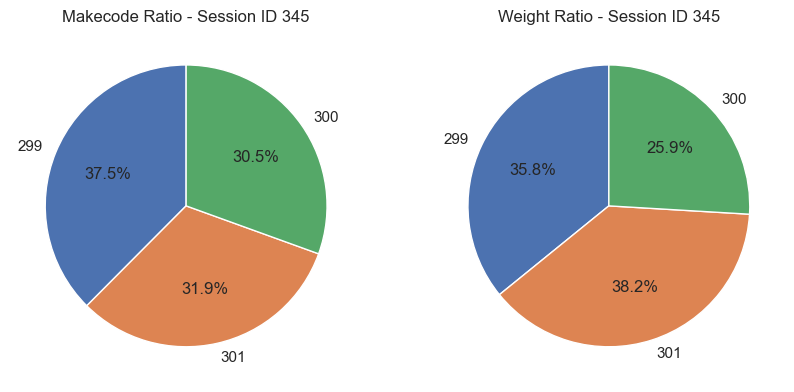

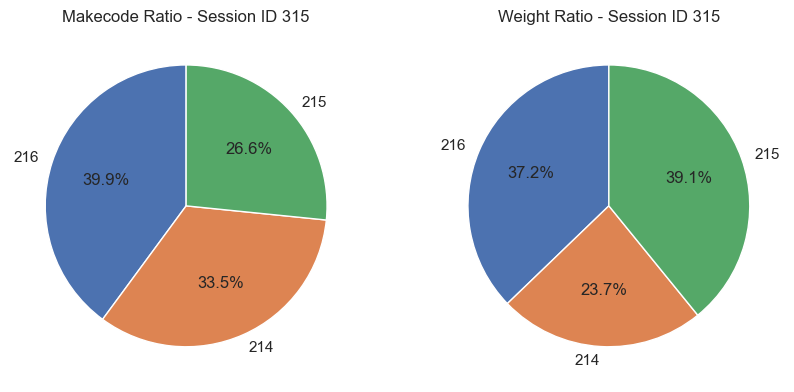

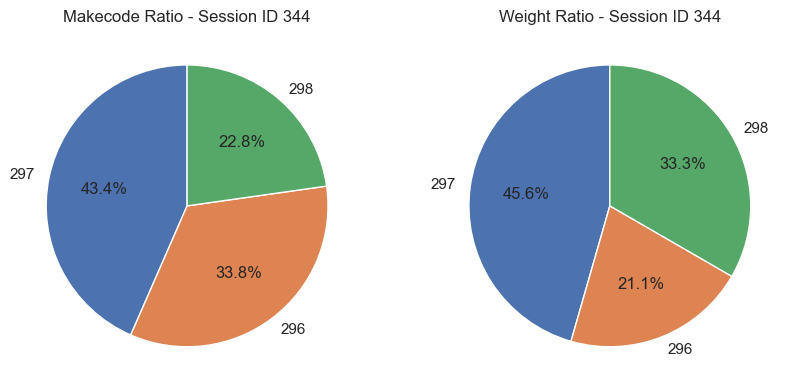

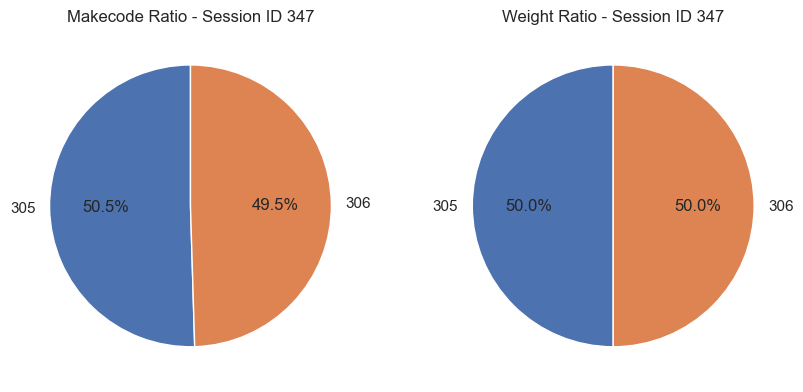

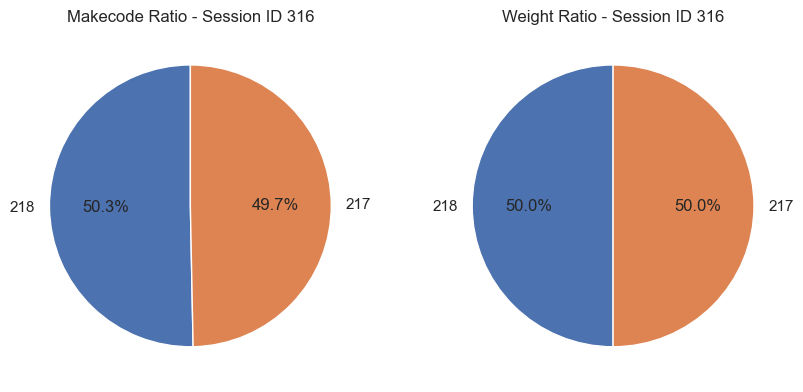

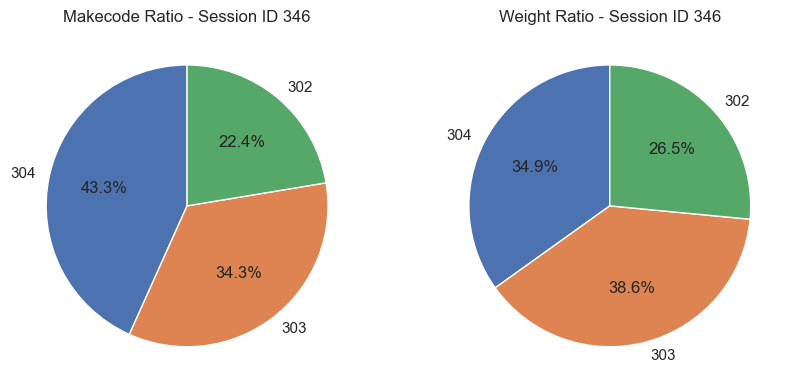

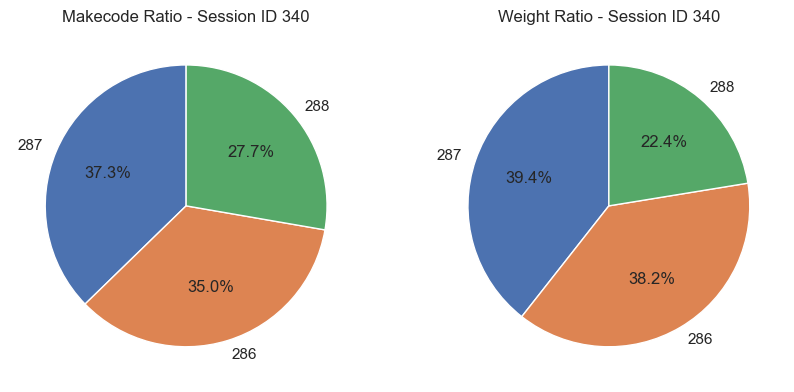

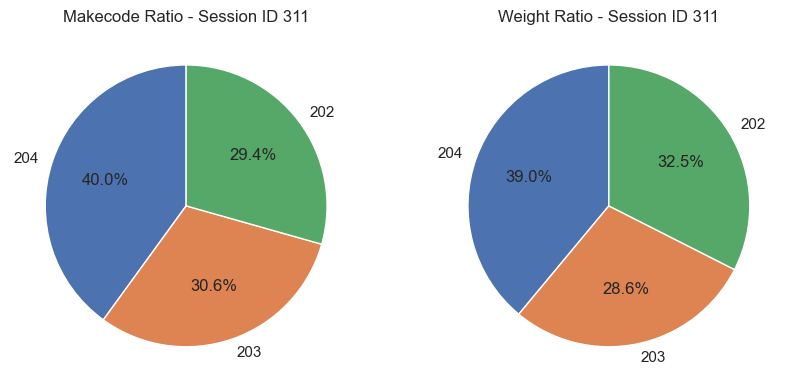

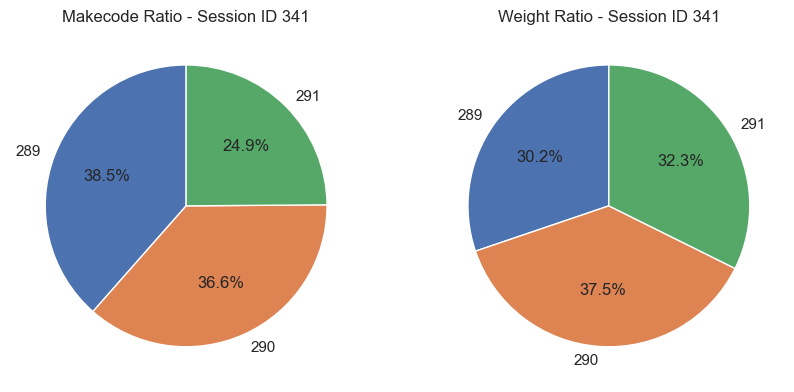

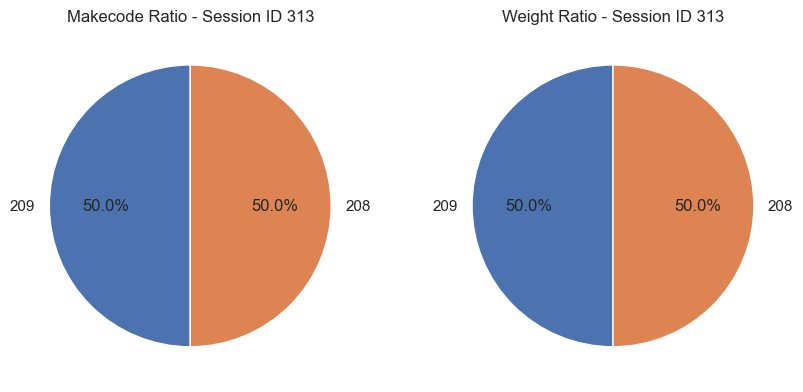

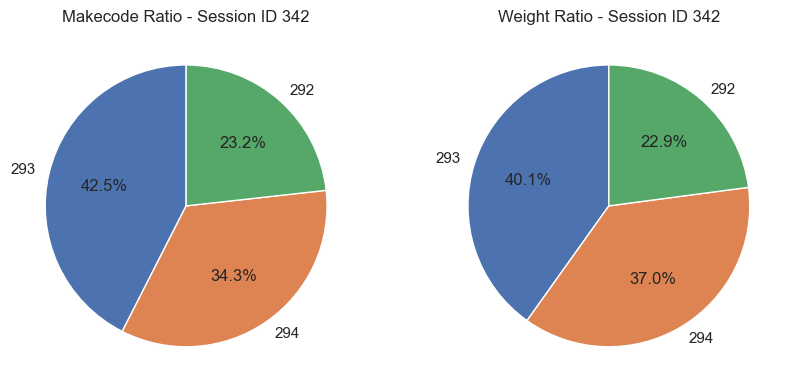

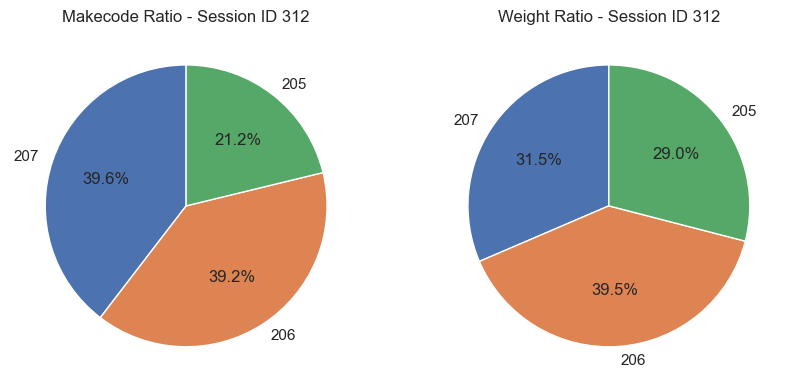

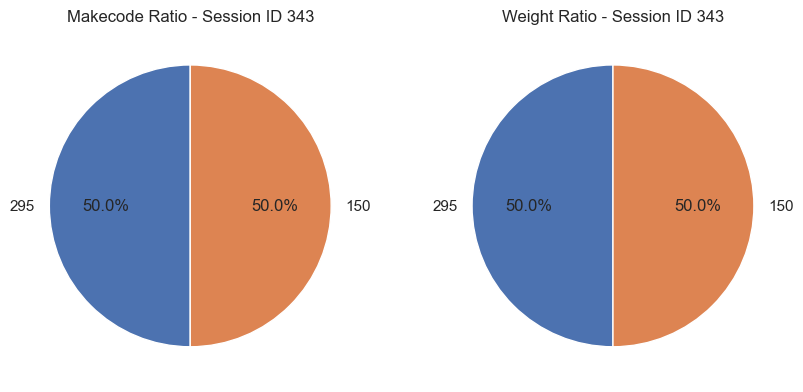

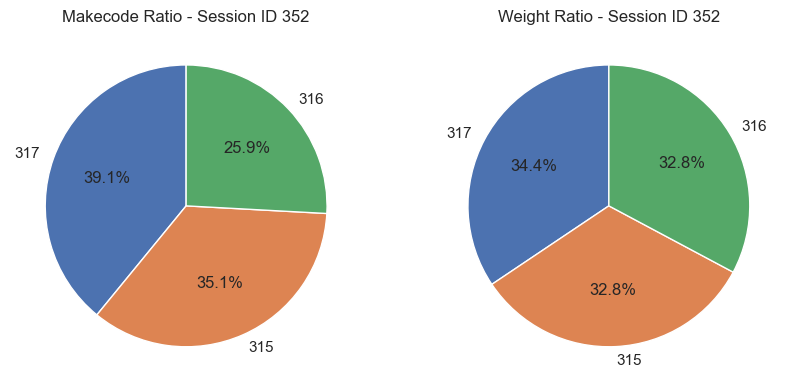

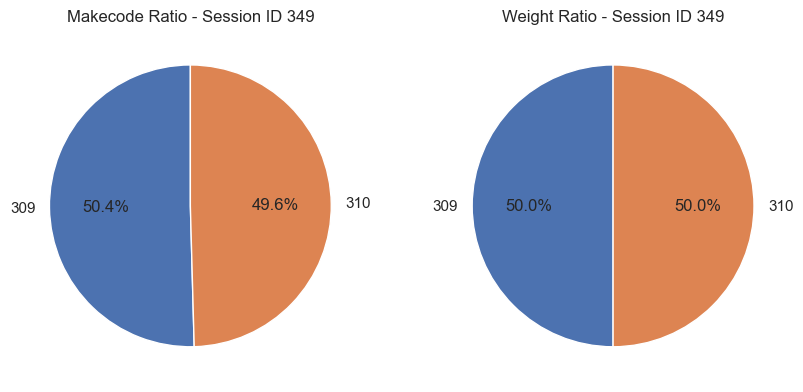

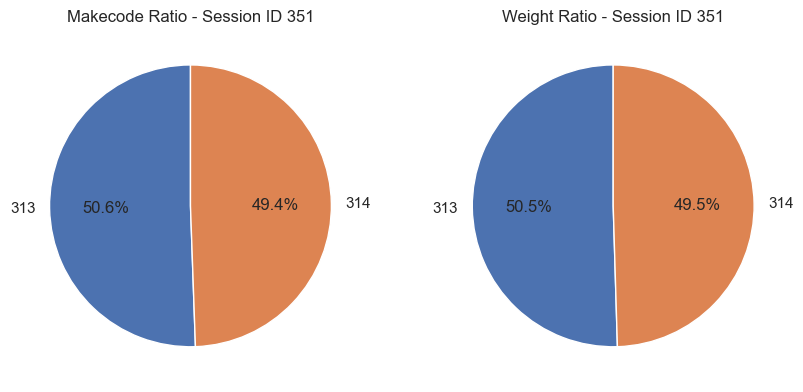

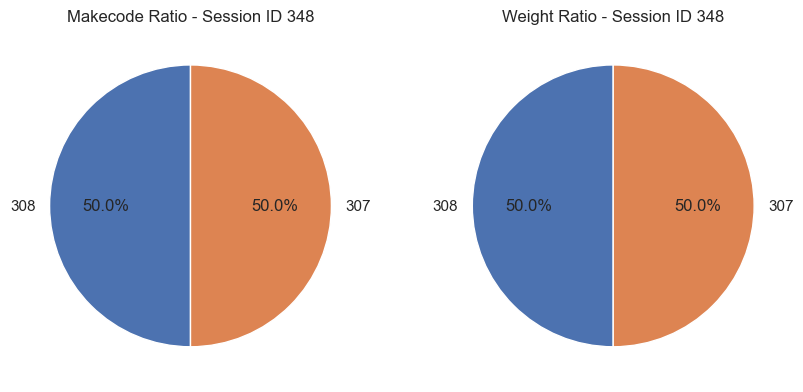

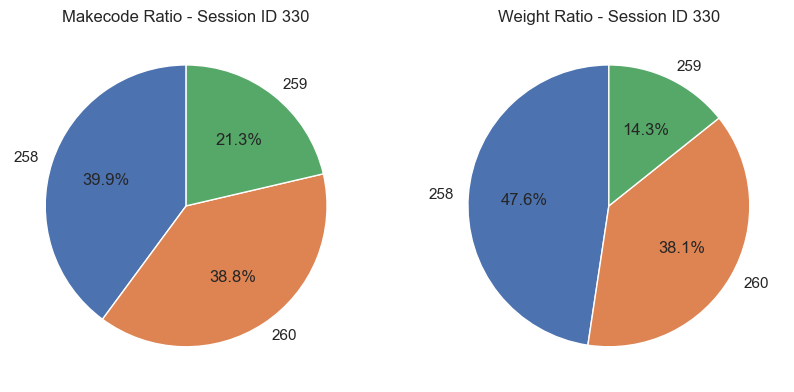

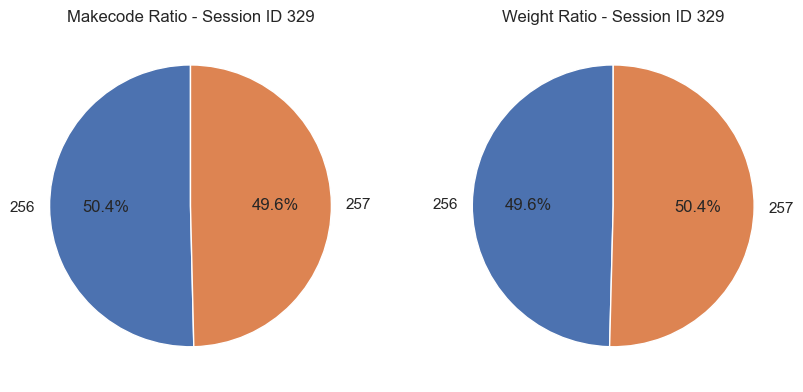

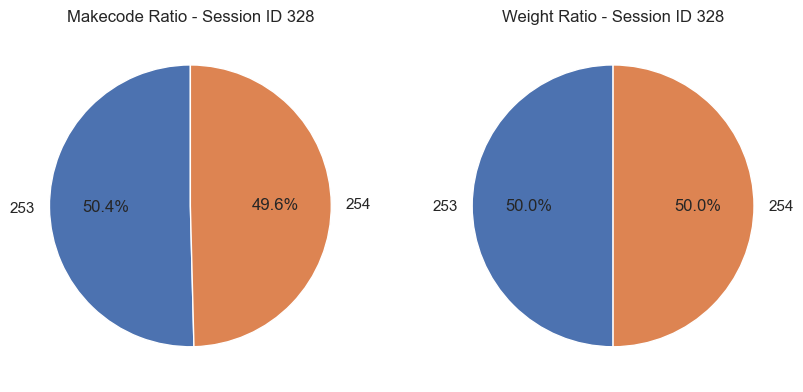

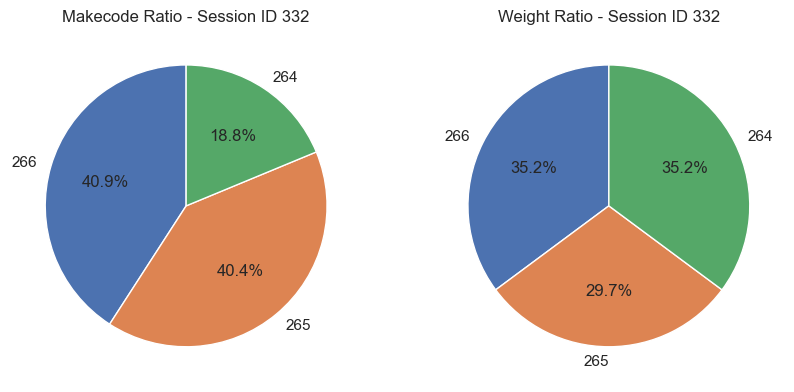

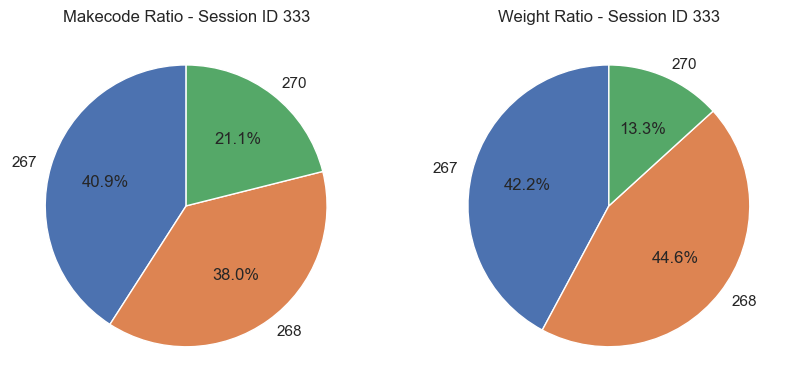

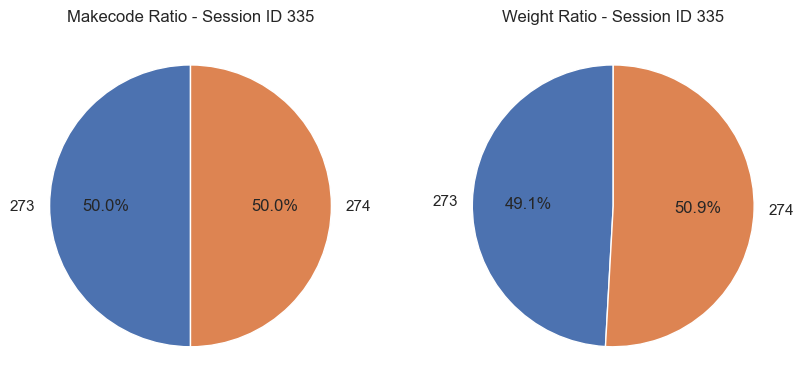

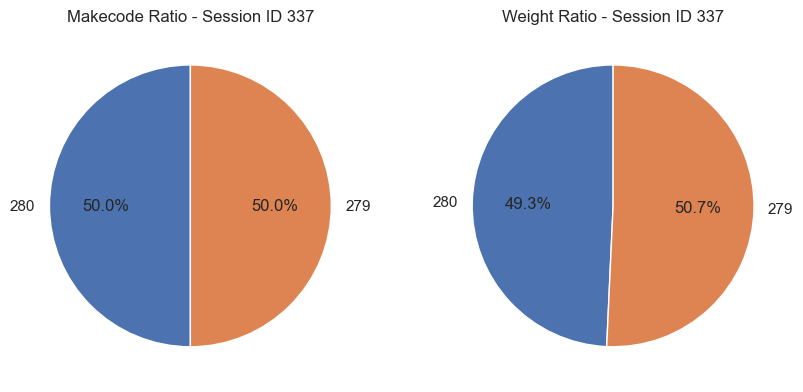

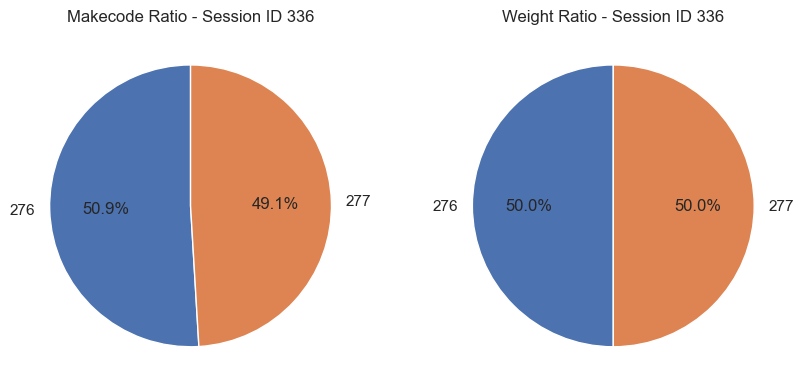

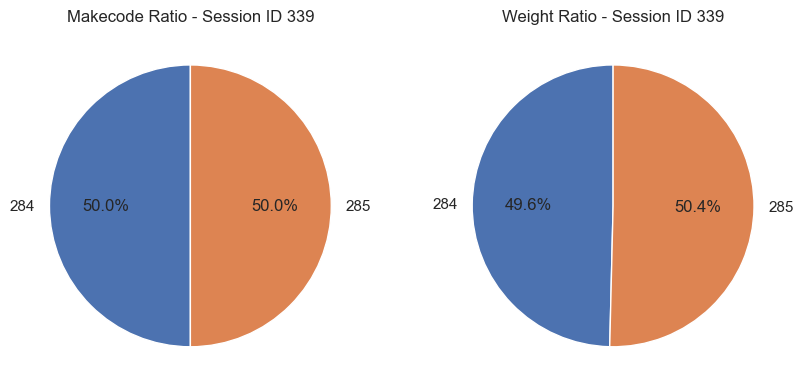

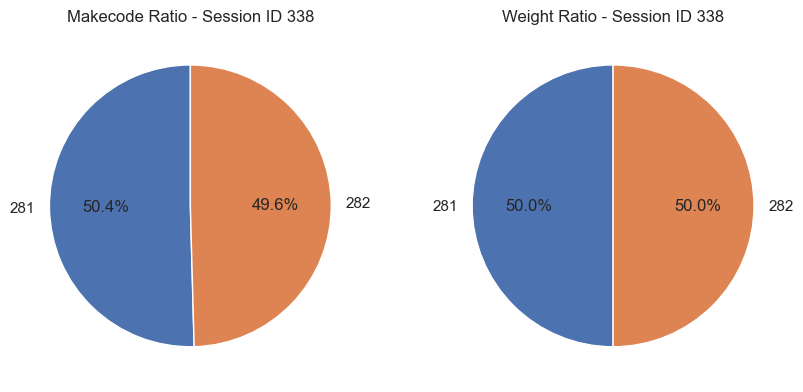

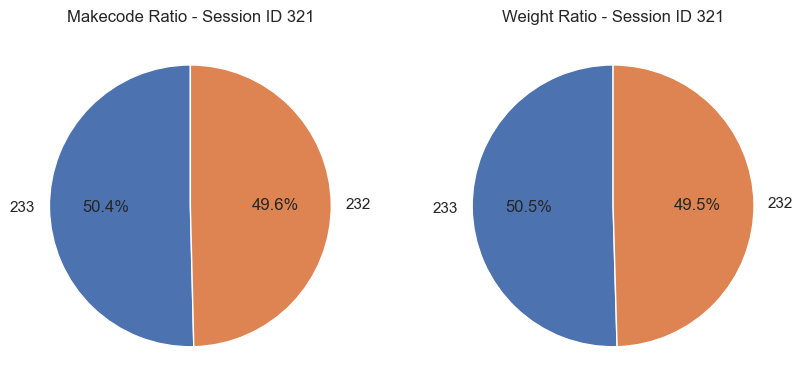

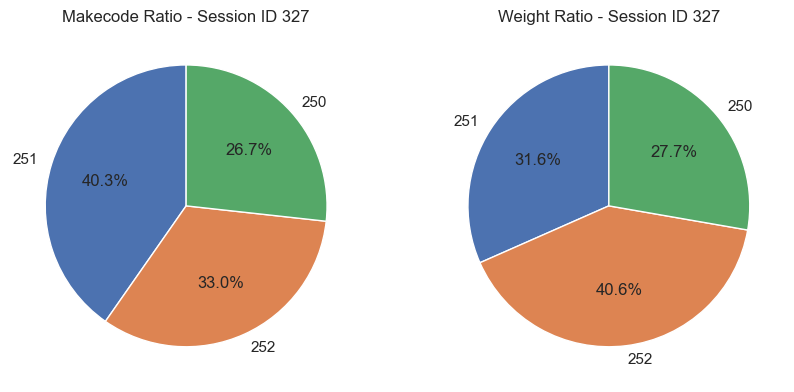

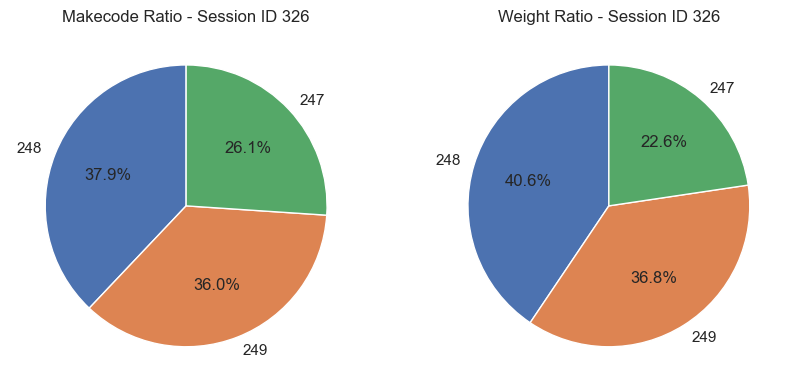

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
session_ids = merged_df['Session_ID'].unique()

for session_id in session_ids:
    plt.figure(figsize=(10, 6))
    
    # Filter the DataFrame for the specific session ID
    session_data = merged_df[merged_df['Session_ID'] == session_id]
    
    # Plot pie chart for makecode_ratio
    plt.subplot(1, 2, 1)
    plt.pie(session_data['makecode_ratio'], labels=session_data['Speaker'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Makecode Ratio - Session ID {session_id}')
    
    # Plot pie chart for weight_ratio
    plt.subplot(1, 2, 2)
    plt.pie(session_data['weight_ratio'], labels=session_data['Speaker'], autopct='%1.1f%%', startangle=90)
    plt.title(f'Weight Ratio - Session ID {session_id}')
    output_directory='/Users/emilydoherty/Library/CloudStorage/OneDrive-UCB-O365/Emily_Papers/iSAT_discoursepaper2023/Other Measures/Plots/utterance_ratios'
    output_file_path = os.path.join(output_directory, f'session_{session_id}_ratios_pie_chart.png')
    plt.savefig(output_file_path)
    plt.show()

